# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_TOD/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov
from simulation import * 

## A. Visualise the experimental setup

In [2]:
nside = 64

In [3]:
# Get the timestream of beam centers (theta_c, phi_c) for each scan
_, eq_coords_setting = sim_MeerKAT_scan(elevation=41.5, az_s=-60.3, az_e=-42.3, start_time_utc="2019-04-23 20:41:56.397", return_eq_coords=True)
_, theta_c_setting, phi_c_setting = sim_MeerKAT_scan(elevation=41.5, az_s=-60.3, az_e=-42.3, start_time_utc="2019-04-23 20:41:56.397")
bool_map_setting, integrated_beam_setting = stacked_beam_map(theta_c_setting, 
                                       phi_c_setting, 
                                       FWHM=1.1, 
                                       NSIDE=nside, 
                                       threshold = 0.0111) # This threshold cut off the beam directions outside the 3sigma region.

_, eq_coords_rising = sim_MeerKAT_scan(elevation=40.5, az_s=43.7, az_e=61.7, start_time_utc="2019-03-30 17:19:02.397", return_eq_coords=True)
t_list, theta_c_rising, phi_c_rising = sim_MeerKAT_scan(elevation=40.5, az_s=43.7, az_e=61.7, start_time_utc="2019-03-30 17:19:02.397")
bool_map_rising, integrated_beam_rising = stacked_beam_map(theta_c_rising, 
                                                            phi_c_rising, 
                                                            FWHM=1.1, 
                                                            NSIDE=nside, 
                                                            threshold = 0.0111)

In [4]:
full_bool_map, pixel_indices = reduce_bool_maps_LOR([bool_map_setting, bool_map_rising])
integrated_beam = integrated_beam_setting + integrated_beam_rising

Tsky_operator_setting = generate_Tsky_proj(full_bool_map, theta_c_setting, phi_c_setting, FWHM=1.1)
Tsky_operator_rising = generate_Tsky_proj(full_bool_map, theta_c_rising, phi_c_rising, FWHM=1.1)

In [5]:
def sky_vector(pixel_indices, freq, Nside=64, sky_model=None):
    if sky_model is None:
        from pygdsm import GlobalSkyModel
        gsm = GlobalSkyModel()
        skymap = gsm.generate(freq)
    else:
        skymap = sky_model(freq)
    skymap = hp.ud_grade(skymap, nside_out=Nside)
    ptsrc = np.load("gleam_nside512_K_allsky_408MHz.npy")
    ptsrc_map = hp.ud_grade(ptsrc, nside_out=Nside)
    skymap = skymap + ptsrc_map
    return skymap[pixel_indices]

In [6]:
pixel_indices_setting = np.where(bool_map_setting)[0]
pixel_indices_rising = np.where(bool_map_rising)[0]
sky_params_setting = sky_vector(pixel_indices_setting, 408, Nside=nside, sky_model=None)
sky_params_rising = sky_vector(pixel_indices_rising, 408, Nside=nside, sky_model=None)
n_cal_pixs=1
top_20_beam_indices = np.argpartition(integrated_beam_setting[pixel_indices_setting], -20)[-20:]
top_n_sky_indices = np.argpartition(sky_params_setting[top_20_beam_indices], -n_cal_pixs)[-n_cal_pixs:]
calibration_indices = top_20_beam_indices[top_n_sky_indices]
pixel_indices_setting_1 = pixel_indices_setting[calibration_indices]
print(pixel_indices_setting_1)

# For a 1D array 'integrated_beam_setting'
n_cal_pixs= 5
top_200_beam_indices = np.argpartition(integrated_beam_setting[pixel_indices_setting], -200)[-200:]
calibration_5_indices = [top_200_beam_indices[int(i* 200 / n_cal_pixs)] for i in range(n_cal_pixs)]
pixel_indices_setting_5 = pixel_indices_setting[calibration_5_indices]


[21996]


In [7]:
sky_params = sky_vector(pixel_indices, 408, Nside=nside, sky_model=None)
print("Number of pixels: ", len(pixel_indices))

# For a 1D array 'integrated_beam_setting'
n_cal_pixs=1
top_20_beam_indices = np.argpartition(integrated_beam[pixel_indices], -20)[-20:]
top_n_sky_indices = np.argpartition(sky_params[top_20_beam_indices], -n_cal_pixs)[-n_cal_pixs:]
calibration_db_indices = top_20_beam_indices[top_n_sky_indices]
pixel_indices_db_1 = pixel_indices[calibration_db_indices]

# For a 1D array 'integrated_beam_setting'
n_cal_pixs= 5
top_200_beam_indices = np.argpartition(integrated_beam[pixel_indices], -200)[-200:]
calibration_db_5indices = [top_200_beam_indices[int(i* 200 / n_cal_pixs)] for i in range(n_cal_pixs)]
pixel_indices_db_5 = pixel_indices[calibration_db_5indices]

Number of pixels:  473


In [8]:
# Obtain (RA, DEC) coordinates for the pixels:
# For pixel_indices_setting_1:
theta_s_1, phi_s_1 = hp.pix2ang(nside, pixel_indices_setting_1)
ra_s_1 = np.degrees(phi_s_1)
dec_s_1 = 90.0 - np.degrees(theta_s_1) 

theta_s_5, phi_s_5 = hp.pix2ang(nside, pixel_indices_setting_5)
ra_s_5 = np.degrees(phi_s_5)
dec_s_5 = 90.0 - np.degrees(theta_s_5) 

theta_db_1, phi_db_1 = hp.pix2ang(nside, pixel_indices_db_1)
ra_db_1 = np.degrees(phi_db_1)
dec_db_1 = 90.0 - np.degrees(theta_db_1)

theta_db_5, phi_db_5 = hp.pix2ang(nside, pixel_indices_db_5)
ra_db_5 = np.degrees(phi_db_5)
dec_db_5 = 90.0 - np.degrees(theta_db_5)

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_16366/967783807.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ra_s_1, dec_s_1,
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_16366/967783807.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ra_db_5, dec_db_5,


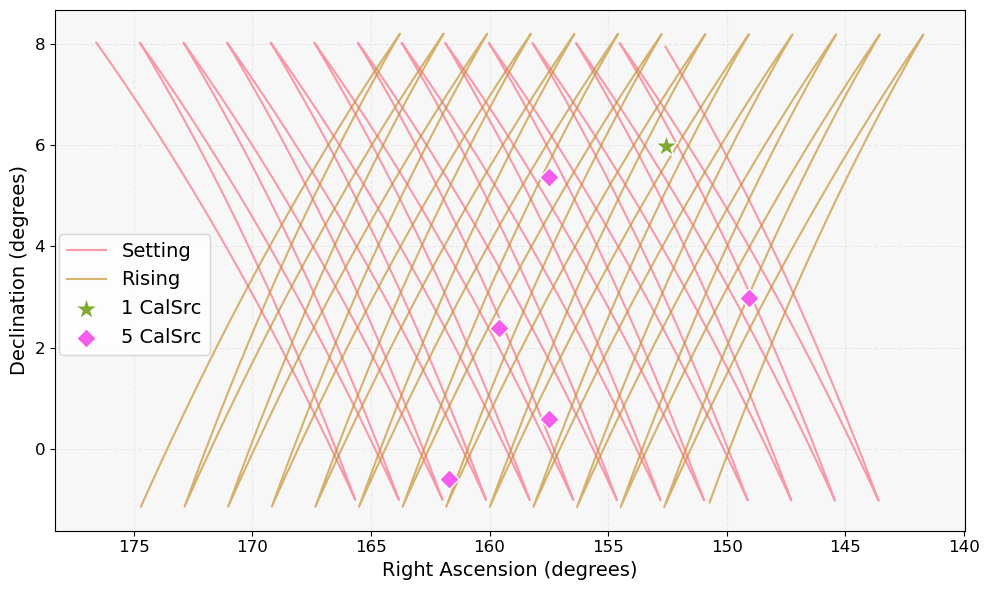

In [9]:
import seaborn as sns


# ---- Plot results ----
plt.figure(figsize=(10, 6))

# Use seaborn color palette
colors = sns.color_palette('husl', 7)

# Plot trajectories with transparency
plt.plot(eq_coords_setting.ra, eq_coords_setting.dec, 
         color=colors[0], 
         alpha=0.7,
         linewidth=1.5,
         label='Setting')
plt.plot(eq_coords_rising.ra, eq_coords_rising.dec, 
         color=colors[1],
         alpha=0.7,
         linewidth=1.5,
         label='Rising')

# Scatter plot with consistent styling

marker_params = {
    'edgecolors': 'w',
    'linewidths': 1,
    'zorder': 3
}

plt.scatter(ra_s_1, dec_s_1, 
            marker='*',
            c=colors[2],
            s=300,
            **marker_params,
            label='1 CalSrc')
# plt.scatter(ra_s_5, dec_s_5,
#             marker='s',
#             c=colors[4],
#             s=100,
#             **marker_params,
#             label='5 CalSrc')
plt.scatter(ra_db_5, dec_db_5,
            marker='D',
            c=colors[6],
            s=100,
            **marker_params,
            label='5 CalSrc')

# Styling enhancements
plt.xlabel("Right Ascension (degrees)", fontsize=14)
plt.ylabel("Declination (degrees)", fontsize=14)
# plt.title("Celestial Coordinates Observation Pattern", fontsize=14, pad=20)
plt.grid(True, alpha=0.2, linestyle='--')
plt.gca().set_facecolor('#f7f7f7')
plt.gca().invert_xaxis() 

# Legend with better placement
plt.legend(bbox_to_anchor=(0.17, 0.57),
           borderaxespad=0,
           frameon=True,
           # title=' '
           fontsize=14
           )

# Adjusting the ticks labels size
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig("observation_pattern_2.pdf", bbox_inches='tight',
            pad_inches=0.1)
plt.show()

/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_16366/1707524116.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ra_s_1, dec_s_1,
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_16366/1707524116.py:28: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ra_s_5, dec_s_5,


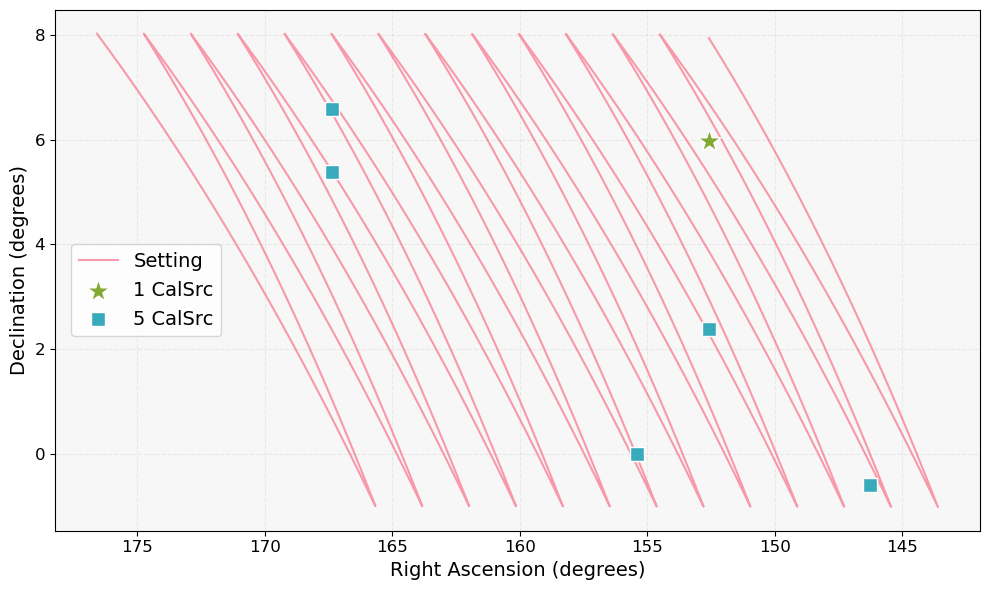

In [10]:
# ---- Plot results ----
plt.figure(figsize=(10, 6))

# Use seaborn color palette
colors = sns.color_palette('husl', 7)

# Plot trajectories with transparency
plt.plot(eq_coords_setting.ra, eq_coords_setting.dec, 
         color=colors[0], 
         alpha=0.7,
         linewidth=1.5,
         label='Setting')

# Scatter plot with consistent styling

marker_params = {
    'edgecolors': 'w',
    'linewidths': 1,
    'zorder': 3
}

plt.scatter(ra_s_1, dec_s_1, 
            marker='*',
            c=colors[2],
            s=300,
            **marker_params,
            label='1 CalSrc')
plt.scatter(ra_s_5, dec_s_5,
            marker='s',
            c=colors[4],
            s=100,
            **marker_params,
            label='5 CalSrc')

# Styling enhancements
plt.xlabel("Right Ascension (degrees)", fontsize=14)
plt.ylabel("Declination (degrees)", fontsize=14)
# plt.title("Celestial Coordinates Observation Pattern", fontsize=14, pad=20)
plt.grid(True, alpha=0.2, linestyle='--')
plt.gca().set_facecolor('#f7f7f7')
plt.gca().invert_xaxis() 

# Legend with better placement
plt.legend(bbox_to_anchor=(0.18, 0.55),
           borderaxespad=0,
           frameon=True,
           # title=' '
           fontsize=14
           )

# Adjusting the ticks labels size
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig("observation_pattern_1.pdf", bbox_inches='tight',
            pad_inches=0.1)
plt.show()

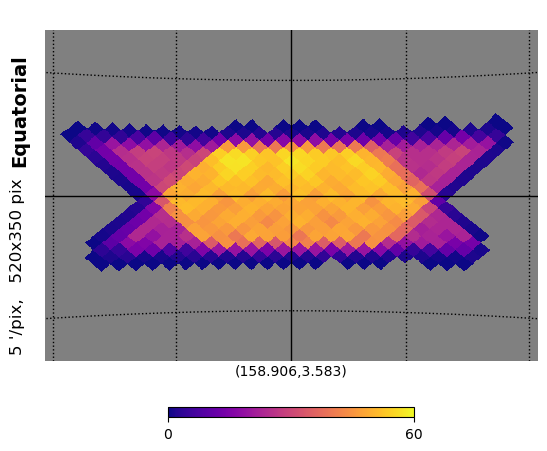

In [11]:
# Get pixel coordinates
theta, phi = hp.pix2ang(nside, pixel_indices)
lon, lat = np.degrees(phi), 90 - np.degrees(theta)
lon_center, lat_center = np.median(lon), np.median(lat)

# Calculate appropriate zoom/resolution
patch_size = 100  # Add 20% margin
res = patch_size / 20  # Adjust resolution based on patch size

def view_patch_map(map, pixel_indices):
    # Create a new map with just the patch (other pixels set to UNSEEN)
    patch_only_map = np.full(len(map), hp.UNSEEN)
    patch_only_map[pixel_indices] = map[pixel_indices]
    return patch_only_map

patch_integrated_beam = view_patch_map(integrated_beam, pixel_indices)

hp.gnomview(patch_integrated_beam, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, 
           title=" ", 
           #unit="K", 
           cmap='plasma',
           min=0, max=60,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig('integrated_beam_2.pdf', bbox_inches='tight', 
            pad_inches=0.1)

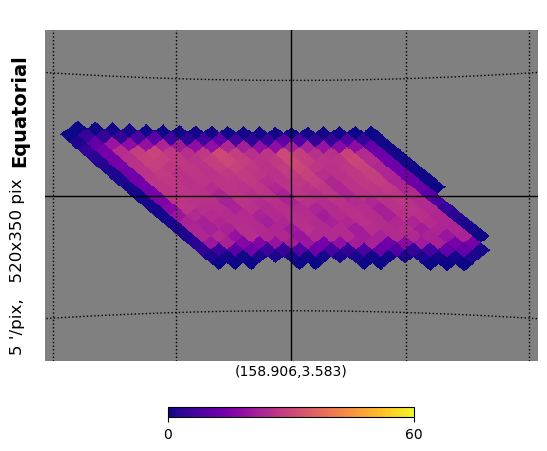

In [12]:
theta, phi = hp.pix2ang(nside, pixel_indices_setting)
lon, lat = np.degrees(phi), 90 - np.degrees(theta)
lon_center, lat_center = np.median(lon), np.median(lat)

# Calculate appropriate zoom/resolution
patch_size = 100  # Add 20% margin
res = patch_size / 20  # Adjust resolution based on patch size

def view_patch_map(map, pixel_indices):
    # Create a new map with just the patch (other pixels set to UNSEEN)
    patch_only_map = np.full(len(map), hp.UNSEEN)
    patch_only_map[pixel_indices] = map[pixel_indices]
    return patch_only_map

patch_integrated_beam = view_patch_map(integrated_beam_setting, pixel_indices_setting)

hp.gnomview(patch_integrated_beam, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, 
           title=" ", 
           #unit="K", 
           cmap='plasma',
           min=0, max=60,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style

plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig('integrated_beam_1.pdf', bbox_inches='tight', 
            pad_inches=0.1)

# B. Visualise the samples

In [ ]:
alpha = 2.0
logf0=-4.874571109426952
gain_params_setting = np.array([6.31194264, 0.42038942, 0.264222, 0.05578821])
gain_params_rising = np.array([6.84507868, 0.14156859, 0.7441104, 0.77863955])
rec_params = np.array([10.0, 4, 0.5, 0.5, 0.5])

In [ ]:
true_others_1 = np.hstack((gain_params_setting, rec_params, []))

In [14]:
def intersect_with_indices(arr1, arr2):
    """
    Returns the intersection of arr1 and arr2, along with the indices in arr1 and arr2.
    """
    import numpy as np
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    intersection, idx_arr1, idx_arr2 = np.intersect1d(arr1, arr2, return_indices=True)
    return intersection, idx_arr1, idx_arr2

def get_subset_indices(pixel_indices, pixel_indices_setting):
    """
    Returns the indices in pixel_indices corresponding to each value in pixel_indices_setting.
    Assumes all elements of pixel_indices_setting are present in pixel_indices.
    """
    import numpy as np
    pixel_indices = np.asarray(pixel_indices)
    pixel_indices_setting = np.asarray(pixel_indices_setting)
    # Create a mapping from value to index for fast lookup
    value_to_index = {val: idx for idx, val in enumerate(pixel_indices)}
    # Get the indices for each value in pixel_indices_setting
    indices = [value_to_index[val] for val in pixel_indices_setting]
    return np.array(indices)

common_pix, _, _ = intersect_with_indices(pixel_indices_setting, pixel_indices_rising)
print(len(common_pix))

inds_common_pix_in_setting = get_subset_indices(pixel_indices_setting, common_pix)
inds_common_pix_in_db = get_subset_indices(pixel_indices, common_pix)

292


In [15]:
# Read the saved samples

GS1_Tsys_samples = np.load('outputs/GS1/Tsys_samples.npy')
GS1_gain_samples = np.load('outputs/GS1/gain_samples.npy')
GS1_noise_samples = np.load('outputs/GS1/noise_samples.npy')
GS1_Tsky = GS1_Tsys_samples[:, :-5]
GS1_Tsky_mean = np.mean(GS1_Tsky, axis=0)
GS1_Tsky_residual = GS1_Tsky_mean - sky_params_setting
GS1_Tsky_residual_common = GS1_Tsky_residual[inds_common_pix_in_setting]
GS1_others = np.hstack((GS1_gain_samples[0], GS1_Tsys_samples[:, -5:], GS1_noise_samples[0]))

GS5_Tsys_samples = np.load('outputs/GS5/Tsys_samples.npy')
GS5_gain_samples = np.load('outputs/GS5/gain_samples.npy')
GS5_noise_samples = np.load('outputs/GS5/noise_samples.npy')
GS5_Tsky = GS5_Tsys_samples[:, :-5]
GS5_Tsky_mean = np.mean(GS5_Tsky, axis=0)
GS5_Tsky_residual = GS5_Tsky_mean - sky_params_setting
GS5_Tsky_residual_common = GS5_Tsky_residual[inds_common_pix_in_setting]
GS5_others = np.hstack((GS5_gain_samples[0], GS5_Tsys_samples[:, -5:], GS5_noise_samples[0]))

GSF5_Tsys_samples = np.load('outputs/GSF5/Tsys_samples.npy')
GSF5_gain_samples = np.load('outputs/GSF5/gain_samples.npy')
GSF5_noise_samples = np.load('outputs/GSF5/noise_samples.npy')
GSF5_Tsky = GSF5_Tsys_samples[:, :-5]
GSF5_Tsky_mean = np.mean(GSF5_Tsky, axis=0)
GSF5_Tsky_residual = GSF5_Tsky_mean - sky_params_setting
GSF5_Tsky_residual_common = GSF5_Tsky_residual[inds_common_pix_in_setting]
GSF5_others = np.hstack((GSF5_gain_samples[0], GSF5_Tsys_samples[:, -5:], GSF5_noise_samples[0]))

GS1_db_Tsys_samples = np.load('outputs/GS1_db/Tsys_samples.npy')
GS1_db_gain_samples = np.load('outputs/GS1_db/gain_samples.npy')
GS1_db_noise_samples = np.load('outputs/GS1_db/noise_samples.npy')
GS1_db_Tsky = GS1_db_Tsys_samples[:, :-10]
GS1_db_Tsky_mean = np.mean(GS1_db_Tsky, axis=0)
GS1_db_Tsky_residual = GS1_db_Tsky_mean - sky_params
GS1_db_Tsky_residual_common = GS1_db_Tsky_residual[inds_common_pix_in_db]
GS1_db_others = np.hstack((GS1_db_gain_samples[0], GS1_db_gain_samples[1], GS1_db_Tsys_samples[:, -10:], 
                           GS1_db_noise_samples[0], GS1_db_noise_samples[1]))

GS5_db_Tsys_samples = np.load('outputs/GS5_db/Tsys_samples.npy')
GS5_db_gain_samples = np.load('outputs/GS5_db/gain_samples.npy')
GS5_db_noise_samples = np.load('outputs/GS5_db/noise_samples.npy')
GS5_db_Tsky = GS5_db_Tsys_samples[:, :-10]
GS5_db_Tsky_mean = np.mean(GS5_db_Tsky, axis=0)
GS5_db_Tsky_residual = GS5_db_Tsky_mean - sky_params
GS5_db_Tsky_residual_common = GS5_db_Tsky_residual[inds_common_pix_in_db]
GS5_db_others = np.hstack((GS5_db_gain_samples[0], GS5_db_gain_samples[1], GS5_db_Tsys_samples[:, -10:], 
                           GS5_db_noise_samples[0], GS5_db_noise_samples[1]))

GSF5_db_Tsys_samples = np.load('outputs/GSF5_db/Tsys_samples.npy')
GSF5_db_gain_samples = np.load('outputs/GSF5_db/gain_samples.npy')
GSF5_db_noise_samples = np.load('outputs/GSF5_db/noise_samples.npy')
GSF5_db_Tsky = GSF5_db_Tsys_samples[:, :-10]
GSF5_db_Tsky_mean = np.mean(GSF5_db_Tsky, axis=0)
GSF5_db_Tsky_residual = GSF5_db_Tsky_mean - sky_params
GSF5_db_Tsky_residual_common = GSF5_db_Tsky_residual[inds_common_pix_in_db]
GSF5_db_others = np.hstack((GSF5_db_gain_samples[0], GSF5_db_gain_samples[1], GSF5_db_Tsys_samples[:, -10:], 
                           GSF5_db_noise_samples[0], GSF5_db_noise_samples[1]))


In [16]:
from visualisation import *

The mean residual is:  0.007883626899628944
16th percentile:  -0.09387124546985717
84th percentile:  0.1351248018031336


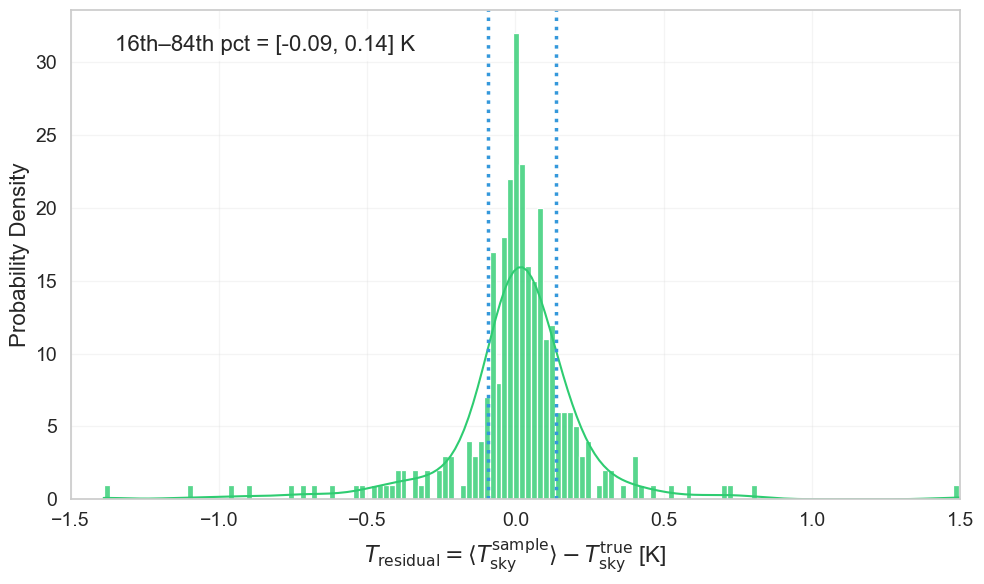

In [18]:
plot_residual_histogram(GS5_Tsky_residual_common, binwidth=0.02, save_path="./GS5_Tsky_residual_hist.pdf")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_parameter_comparison(GS1_others, GS5_others, GSF5_others, true_values, x_labels,
                              bins=50, alpha=0.5, figsize=(15, 4), colors=('skyblue', 'salmon', 'lightgreen'),
                              line_styles=('-', '--', '-.'), ylabel='Frequency'):
    """
    Plot parameter comparison across three different calibration configurations.
    
    Parameters:
    GS1_others, GS5_others, GSF5_others : ndarray
        Arrays of shape (n_samples, n_params) containing samples
    true_values : list
        True parameter values for each parameter
    x_labels : list
        Parameter names for labeling
    bins : int, optional
        Number of histogram bins
    alpha : float, optional
        Histogram transparency (0-1)
    figsize : tuple, optional
        Figure size (width, height)
    colors : tuple, optional
        Colors for each dataset
    line_styles : tuple, optional
        Line styles for [true_value, mean, std]
    ylabel : str, optional
        Label for shared y-axis
    """
    # Line styles for different elements
    TRUE_LS, MEAN_LS, STD_LS = line_styles
    n_params = GS1_others.shape[1]
    
    for p in range(n_params):
        fig, axs = plt.subplots(1, 3, figsize=figsize, sharey=True, sharex=True)
        plt.subplots_adjust(bottom=0.2, wspace=0.05)  # Adjust spacing
        
        datasets = [GS1_others[:, p], GS5_others[:, p], GSF5_others[:, p]]
        titles = ['1 CalSrc', '5 CalSrc', r'5 CalSrc; $1/f$ prior']
        
        for ax, data, color, title in zip(axs, datasets, colors, titles):
            # Plot histogram
            ax.hist(data, bins=bins, alpha=alpha, color=color, density=False)
            
            # Calculate statistics
            mean_val = np.mean(data)
            std_val = np.std(data)
            true_val = true_values[p]
            
            # Add vertical lines
            ax.axvline(true_val, color='k', ls=TRUE_LS, lw=2, label='True value')
            ax.axvline(mean_val, color='purple', ls=MEAN_LS, lw=2, label='Mean')
            ax.axvline(mean_val - std_val, color='darkred', ls=STD_LS, lw=1.5, label='±1 std')
            ax.axvline(mean_val + std_val, color='darkred', ls=STD_LS, lw=1.5)
            
            # Add text annotations
            ax.text(0.95, 0.95, f"μ = {mean_val:.3f}\nσ = {std_val:.3f}",
                    transform=ax.transAxes, ha='right', va='top',
                    bbox=dict(facecolor='white', alpha=0.8, pad=4))
            
            # Subplot titles
            ax.set_title(title, fontsize=12)
            ax.set_xlabel(x_labels[p], fontsize=11)
            ax.grid(alpha=0.2)
            ax.tick_params(axis='both', which='major', labelsize=9)
            
            # Add legend to first subplot only
            if ax == axs[0]:
                ax.set_ylabel(ylabel, fontsize=11)
                handles, labels = ax.get_legend_handles_labels()
                # Filter unique labels
                unique = dict(zip(labels, handles))
                ax.legend(unique.values(), unique.keys(), 
                         loc='upper left', frameon=True, framealpha=0.9)
        
        # Add figure-level statistics
        plt.suptitle(f"Parameter: {x_labels[p]} | True value = {true_values[p]:.3f}", 
                    y=0.05, fontsize=12, ha='center')
        
        plt.show()

# Example usage
plot_parameter_comparison(
    GS1_others, 
    GS5_others, 
    GSF5_others,
    true_values=[0.1, 0.2, ...],  # Replace with actual true values
    x_labels=["Param1", "Param2", ...]  # Replace with actual labels
)

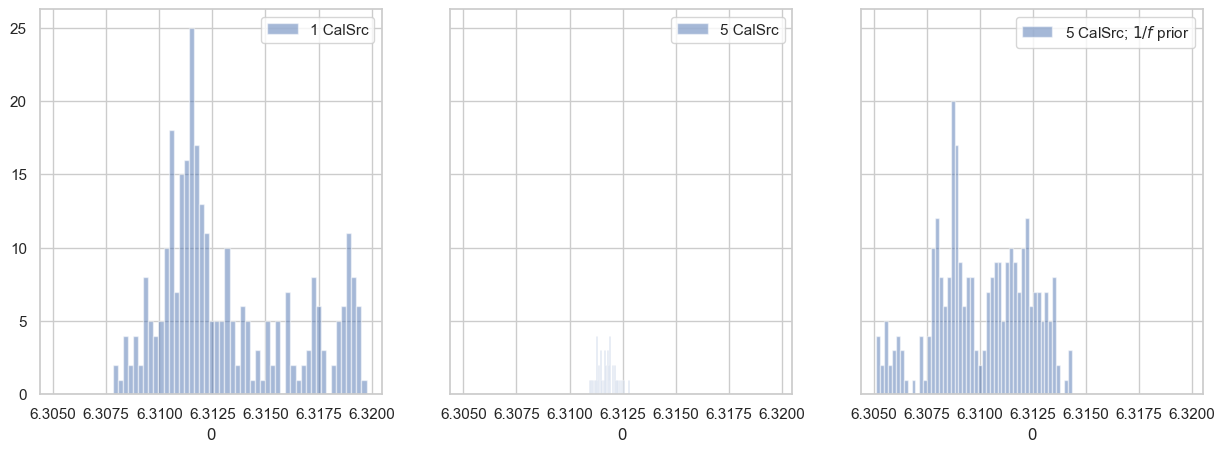

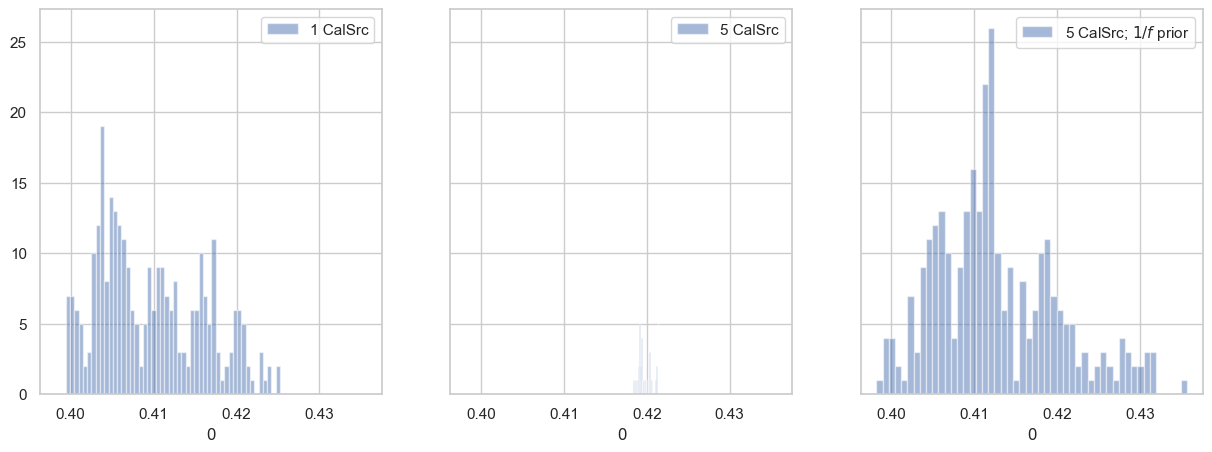

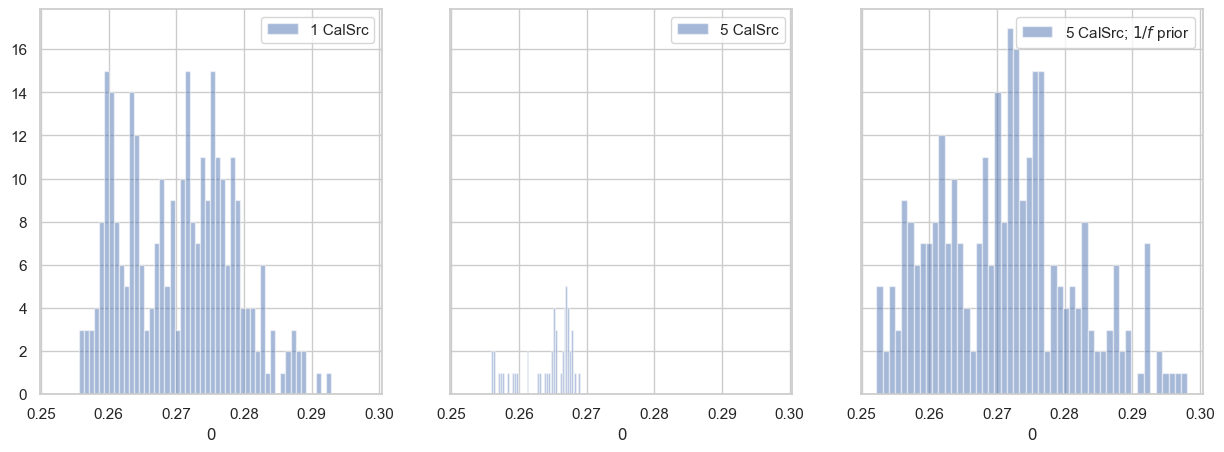

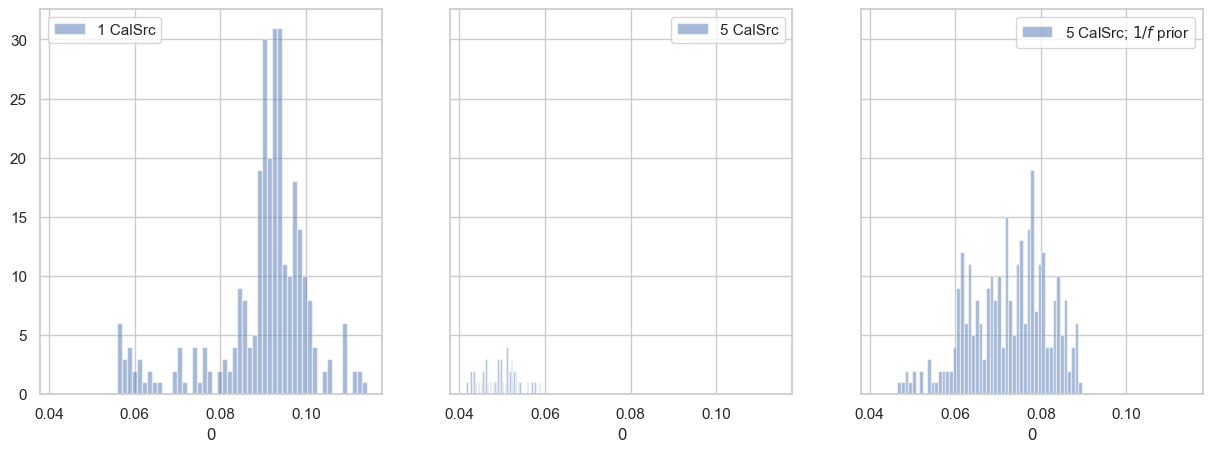

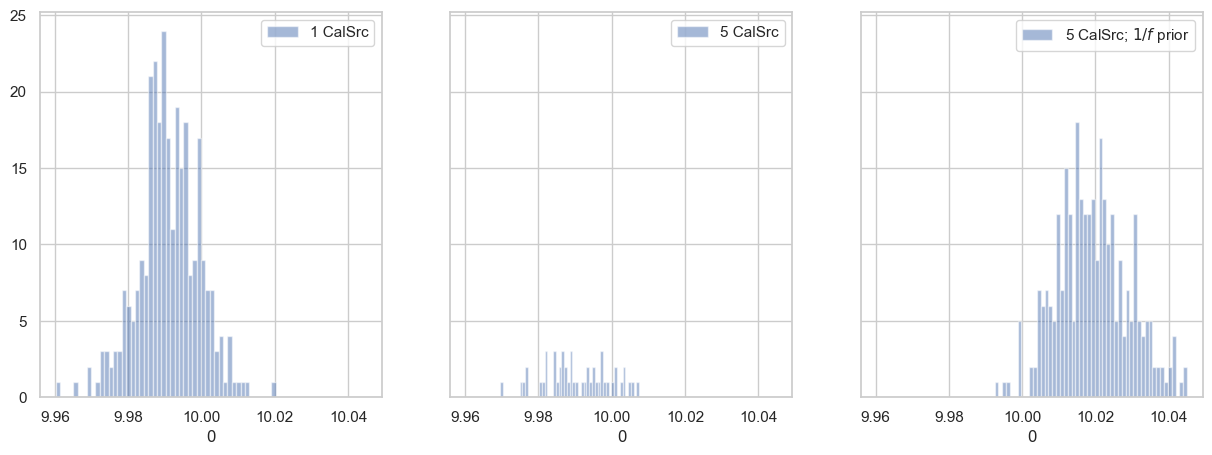

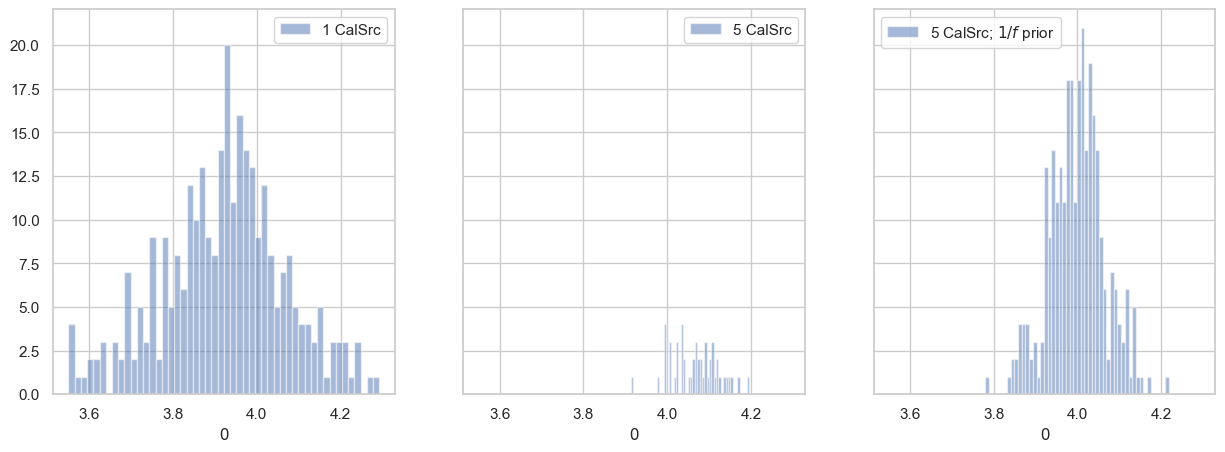

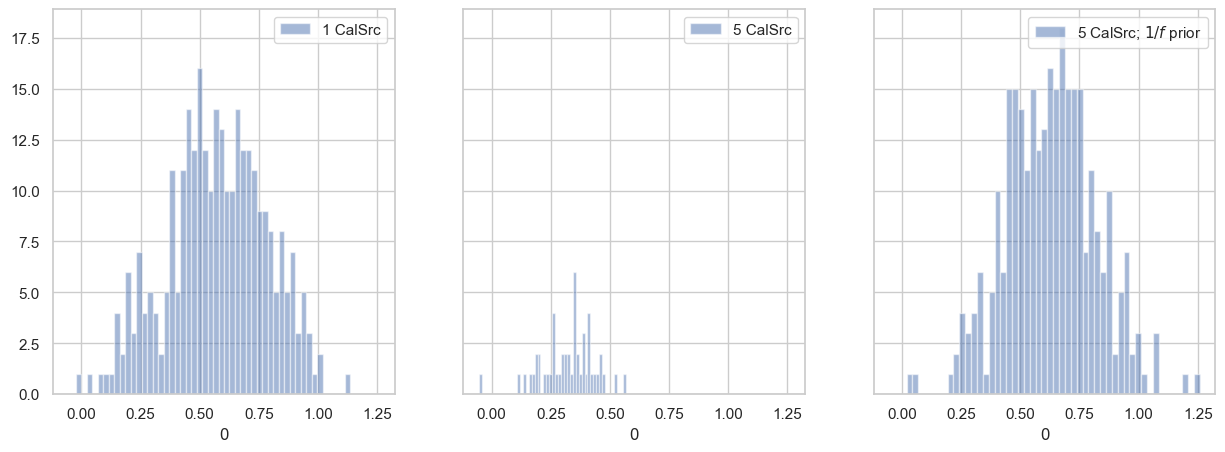

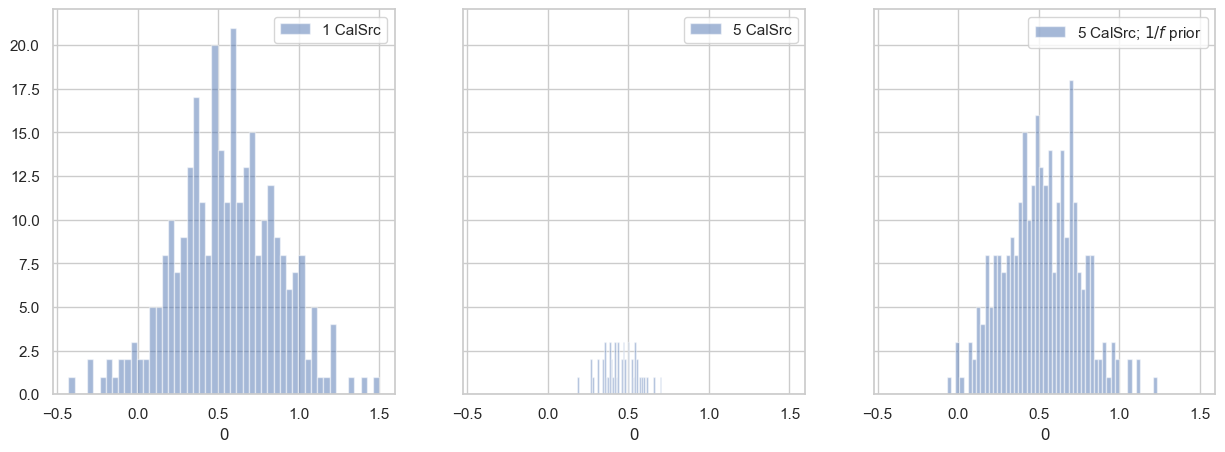

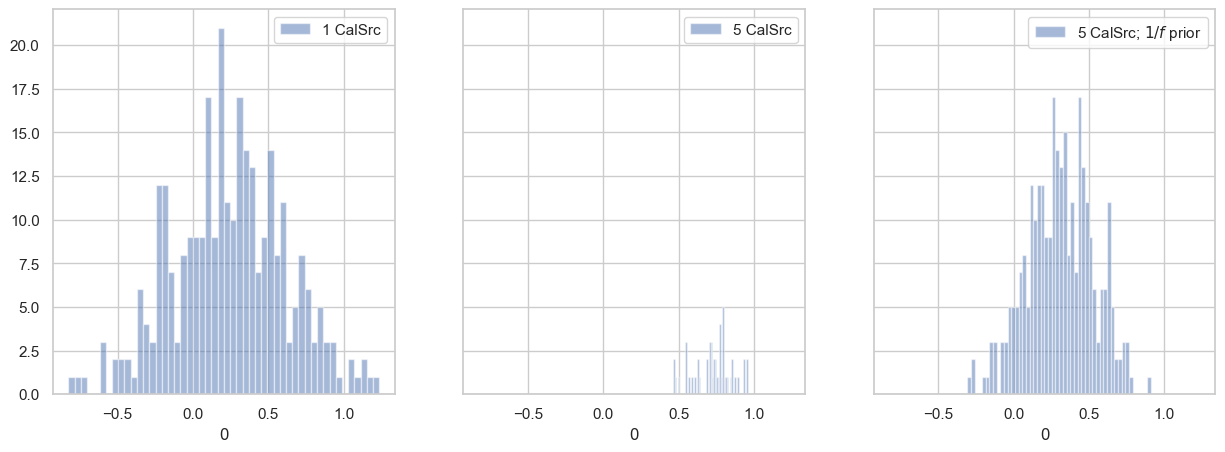

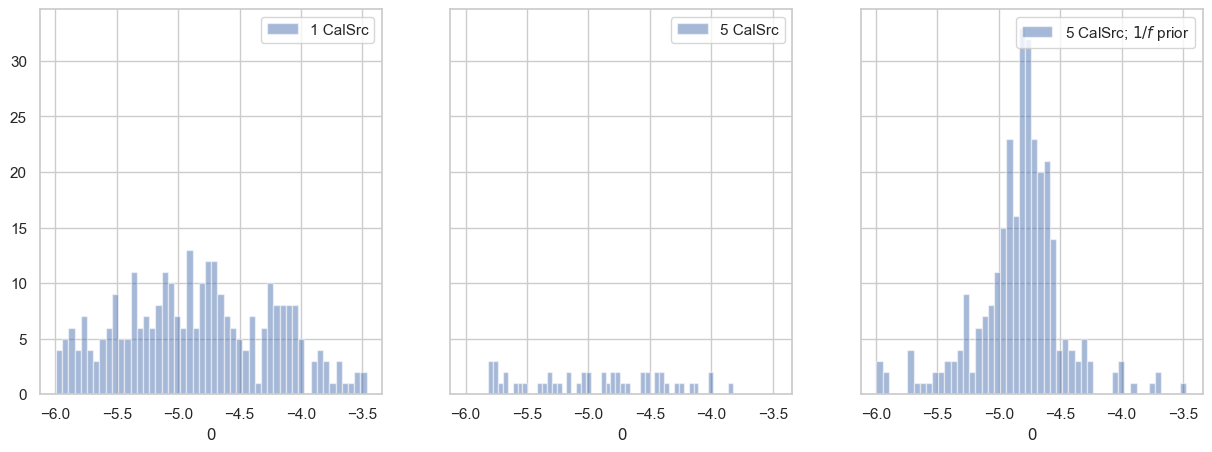

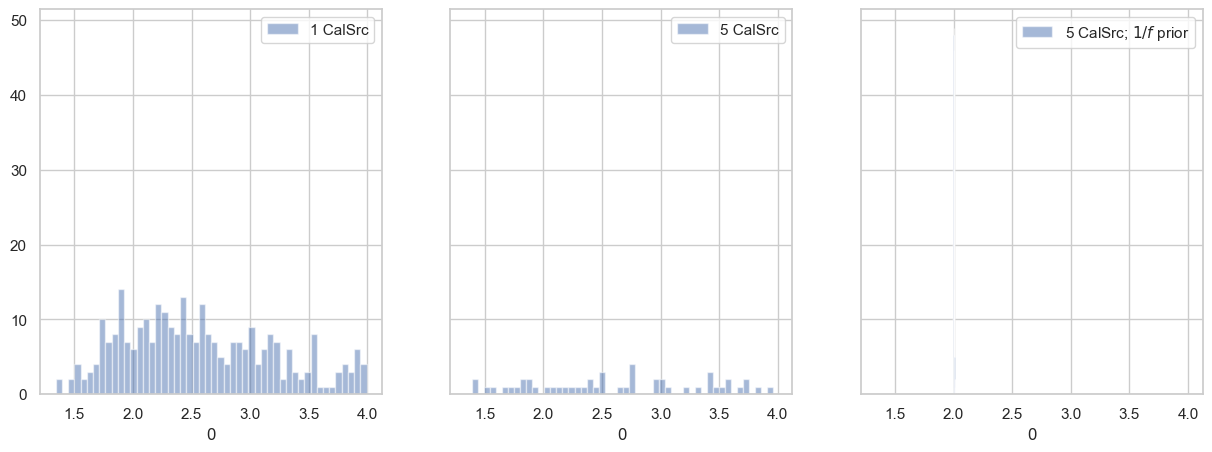

In [ ]:
x_labels = [0]*11
n_params = GS1_others.shape[1]
for p in range(n_params):
    # Make a plot with 1 row and 3 columns
    fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True, sharex=True)
    # Plot the true values
    axs[0].hist(GS1_others[:, p], bins=50, alpha=0.5, label='1 CalSrc')
    axs[1].hist(GS5_others[:, p], bins=50, alpha=0.5, label='5 CalSrc')
    axs[2].hist(GSF5_others[:, p], bins=50, alpha=0.5, label=r'5 CalSrc; $1/f$ prior')
    # Add labels and a legend
    axs[0].set_xlabel(x_labels[p])
    axs[1].set_xlabel(x_labels[p])
    axs[2].set_xlabel(x_labels[p])
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_1d_marginals(samples, labels=None, truths=None, quantiles=[0.16, 0.5, 0.84],
                      bins=50, smooth_kde=True, figsize=(3, 2.5), 
                      hist_color='navy', truth_color='orangered',
                      label_fontsize=14, title_fontsize=12,
                      save_path=None):
    """
    Plots only the 1D marginal histograms (with optional KDE and quantiles) 
    for each parameter in the MCMC samples.

    Parameters:
    -----------
    samples : np.ndarray
        Array of shape (n_samples, n_params) with MCMC samples.
    labels : list of str
        Parameter labels for each dimension.
    truths : list of float or None
        True values to overlay as vertical lines (optional).
    quantiles : list of float
        Quantiles to mark on each histogram (e.g., [0.16, 0.5, 0.84]).
    bins : int
        Number of bins for histograms.
    smooth_kde : bool
        Whether to overlay a KDE curve.
    figsize : tuple
        Size of each subplot.
    hist_color : str
        Color of the histogram.
    truth_color : str
        Color for truth value lines.
    save_path : str or None
        If provided, saves the figure to this path.
    """
    n_params = samples.shape[1]
    if labels is None:
        labels = [f'param {i}' for i in range(n_params)]
    if truths is None:
        truths = [None] * n_params

    fig, axes = plt.subplots(1, n_params, figsize=(figsize[0]*n_params, figsize[1]), constrained_layout=True)

    for i in range(n_params):
        ax = axes[i] if n_params > 1 else axes
        sns.histplot(samples[:, i], bins=bins, kde=smooth_kde,
                     color=hist_color, edgecolor='white', ax=ax)

        qs = np.quantile(samples[:, i], quantiles)
        for q in qs:
            ax.axvline(q, color='black', linestyle='--', linewidth=1)

        if truths[i] is not None:
            ax.axvline(truths[i], color=truth_color, linestyle='-', linewidth=1.5)

        ax.set_xlabel(labels[i], fontsize=label_fontsize)
        ax.set_yticks([])
        ax.tick_params(axis='x', labelsize=label_fontsize - 2)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"1D marginals saved to {save_path}")
    
    plt.show()
    return fig

# plot_1d_marginals(other_samples)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
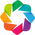

In [24]:
import numpy as np
import pandas as pd
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')


def samples_to_links(samples: np.ndarray, param_names: list, kind: str = 'correlation', threshold: float = 0.3):
    """
    将贝叶斯样本数组转换为和弦图可用的 links dataframe。
    
    Parameters:
    -----------
    samples : np.ndarray
        后验采样数组，形状为 (N_samples, N_params)
    param_names : list of str
        参数名称，长度为 N_params
    kind : str
        使用相关系数 'correlation' 或协方差 'covariance'
    threshold : float
        忽略低于该值（绝对值）的参数对

    Returns:
    --------
    links : pd.DataFrame
        包含 source, target, value（原始相关系数/协方差）, weight（abs值）列
    """
    assert samples.ndim == 2, "samples 必须是二维数组"
    assert samples.shape[1] == len(param_names), "参数名称数量与样本列数不一致"
    assert kind in ['correlation', 'covariance'], "`kind` 只能是 'correlation' 或 'covariance'"

    if kind == 'correlation':
        matrix = np.corrcoef(samples, rowvar=False)
    else:
        matrix = np.cov(samples, rowvar=False)

    edges = []
    for i in range(len(param_names)):
        for j in range(i + 1, len(param_names)):
            val = matrix[i, j]
            abs_val = abs(val)
            if abs_val >= threshold:
                edges.append({
                    'source': param_names[i],
                    'target': param_names[j],
                    'value': val,
                    'weight': abs_val
                })

    return pd.DataFrame(edges)


def plot_chord_from_samples(samples: np.ndarray, param_names: list, threshold: float = 0.3):
    """
    Generate a chord diagram showing correlations between parameters based on posterior samples.
    
    Parameters:
    -----------
    samples : np.ndarray
        Array of shape (N_samples, N_params), posterior samples.
    param_names : list
        List of parameter names (length must match samples.shape[1]).
    threshold : float
        Minimum absolute correlation to show an edge (default=0.3).
    
    Returns:
    --------
    holoviews.element.graphs.Chord
        An interactive Chord diagram object (rendered with Bokeh).
    """
    assert samples.ndim == 2, "samples must be a 2D array"
    assert samples.shape[1] == len(param_names), "Mismatch in number of parameters"
    
    # Compute correlation matrix
    corr_matrix = np.corrcoef(samples, rowvar=False)
    
    # Build edge list: (source, target, weight)
    edges = []
    for i in range(len(param_names)):
        for j in range(i + 1, len(param_names)):
            weight = corr_matrix[i, j]
            if abs(weight) >= threshold:
                edges.append((param_names[i], param_names[j], weight))
    
    # Nodes
    nodes = pd.DataFrame({'name': param_names})
    
    # Edges
    links = pd.DataFrame(edges, columns=['source', 'target', 'value'])
    links['abs_value'] = np.abs(links['value'])  # 用于控制宽度
    
    # Create chord diagram
    chord = hv.Chord((links, hv.Dataset(nodes, 'name')))
    chord.opts(
        opts.Chord(
            height=500, width=500, 
            labels='name',
            cmap='coolwarm',
            edge_color=hv.dim('value'),
            edge_line_width=hv.dim('abs_value') * 5,
            node_color='name',
            title="Parameter Correlation Chord Diagram"
        )
    )
    return chord


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
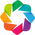

:Chord   [source,target]   (value,weight)

In [54]:
import numpy as np
import pandas as pd
import holoviews as hv
from holoviews import opts

hv.extension('bokeh')  # or 'matplotlib'

def plot_chord_from_samples(samples: np.ndarray,
                            param_names: list,
                            kind: str = 'correlation',
                            threshold: float = 0.3,
                            figsize: int = 600):
    """
    从贝叶斯样本生成和弦图，展示参数间的相关性结构。

    Parameters:
    -----------
    samples : np.ndarray
        形状为 (N_samples, N_params) 的后验采样数组
    param_names : list of str
        参数名称
    kind : str
        使用相关系数 'correlation' 或协方差 'covariance'
    threshold : float
        显示边的绝对值阈值（小于该值的边将被忽略）
    figsize : int
        图像尺寸（像素）

    Returns:
    --------
    hv.Chord object
    """

    assert samples.ndim == 2, "samples 必须是二维数组"
    assert samples.shape[1] == len(param_names), "参数名称数量与样本列数不一致"
    assert kind in ['correlation', 'covariance'], "`kind` 只能是 'correlation' 或 'covariance'"

    # ---------- 1. 构建相关性或协方差矩阵 ----------
    if kind == 'correlation':
        matrix = np.corrcoef(samples, rowvar=False)
    else:
        matrix = np.cov(samples, rowvar=False)

    # 2. 构建边列表时收集实际使用的节点
    used_nodes = set()  # 新增：跟踪实际使用的节点
    edges = []
    for i in range(len(param_names)):
        for j in range(i + 1, len(param_names)):
            val = matrix[i, j]
            if abs(val) >= threshold:
                src = param_names[i]
                tgt = param_names[j]
                edges.append({
                    'source': src,
                    'target': tgt,
                    'value': val,
                    'weight': abs(val)
                })
                # 记录实际使用的节点
                used_nodes.add(src)
                used_nodes.add(tgt)

    if not edges:
        raise ValueError("没有任何边满足给定的 threshold，请降低 threshold 或检查数据。")

    links = pd.DataFrame(edges)
    
    # 3. 节点信息 - 只包含实际使用的节点
    nodes = pd.DataFrame({'name': list(used_nodes)})  # 关键修改：只包含有连接的节点

    # ---------- 4. 构建和弦图 ----------
    chord = hv.Chord((links, hv.Dataset(nodes, 'name')))
    chord = chord.opts(
        opts.Chord(
            width=figsize, height=figsize,
            cmap='RdBu_r', edge_color=hv.dim('value'),
            edge_cmap='RdBu_r', edge_alpha=0.8,
            node_color='name', node_size=15,
            labels='name', label_text_font_size='8pt',
            tools=['hover'], title=f"Chord diagram ({kind}, |value| ≥ {threshold})"
        )
    )
    return chord



param_names = [r'$a_0$', r'$a_1$', r'$a_2$',r'$a_3$', r'$T_{\mathrm{nd}}$',
                                r'$c_0$', r'$c_1$', r'$c_2$',r'$c_3$',
                                r'$\text{log}_{10} f_0$',r'$\alpha$']

chord = plot_chord_from_samples(GS1_others, param_names, kind='covariance', threshold=0)
chord